# Running the GW100 benchmark with python


MOLGW is shipped with a python module that helps us automate the calculations.

Here we want to run a subset of the [GW100 benchmark](https://gw100.wordpress.com/).
It is a collection of the HOMO energies of 100 small molecules with accurate references.


First of all, make sure that the molgw python module can be found:
```sh
export PYTHONPATH=${PYTHONPATH}:/path/to/molgw/utils
```

Imagine we want to calculate the HOMO energies with one-shot $G_0W_0$ based PBEh(0.75) (the othername for PBE0 with 75 % of exact-exchange).

## Preparing the inputs

In [1]:
import molgw
from molgw import Molgw_input, Molgw_output, Molgw_output_collection
from molgw import Molecule

import molgw.gw100

In [2]:
# Get default parameters for the GW100 set
input_param = molgw.gw100.default_input_parameters

# But override some of them just to be sure
input_param['scf'] = 'PBEh'
input_param['alpha_hybrid'] = 0.75
input_param['postscf'] = 'g0w0'
input_param['basis'] = 'Def2-TZVPP'

print(input_param)

{'scf': 'PBEh', 'alpha_hybrid': 0.75, 'postscf': 'g0w0', 'basis': 'Def2-TZVPP', 'ecp_basis': 'Def2-TZVPP', 'auxil_basis': 'pauto', 'ecp_auxil_basis': 'pauto', 'ecp_elements': 'Xe Ag Rb I', 'ecp_type': 'Def2-ECP', 'selfenergy_state_range': 2, 'frozencore': 'yes'}


Remarks:

- The input parameters are quite numerous since some atoms require a pseudopotential.

- `selfenergy_state_range = 2` so that the HOMO $\pm 2$ states are calculated to account for possible state-swapping. This happens for N$_2$ in Hartree-Fock for instance.

## Running the calculations

To keep the calculations reasonable, we limit ourselves to the systems with only one atoms, namely the rare-gas atoms, He, Ne, Ar, Kr, Xe.

In [3]:
# Maximum size of the calculated systems
natom_max = 1

# Create an empty collection of outputs
#mlgos = Molgw_output_collection()
mlgos = {}
for cas, xyz in molgw.gw100.structures.items():
    mol = Molecule(xyz)
    # Limit the calculations to those with few atoms
    if len(mol) > natom_max:
        continue
    print(f"Running: {cas} {molgw.gw100.chemical_formulas[cas]}")
    input_param["xyz"] = mol.to_string()
    # store the CAS number in the comment field
    input_param["comment"]  = cas

    # Prepare an input
    mlgi = Molgw_input(input_param)
    # Run the calculation in a tmp folder and store the results in mlgo
    mlgos[cas] = mlgi.run(tmp="tmp/")
    #mlgos.append(mlgo)

Running: 7440-37-1 Ar
Running: 7440-01-9 Ne
Running: 7440-63-3 Xe
Running: 7439-90-9 Kr
Running: 7440-59-7 He


This should take less than a minute.
If you want a larger set, increase `natom_max` to 2 or more

## Analyzing the results

Now we would like to compare with the reference CCSD(T) energies published in [The GW Miracle in Many-Body Perturbation Theory for the Ionization Potential of Molecules](https://doi.org/10.3389/fchem.2021.749779).

Fortunately, `molgw.gw100.ccsdt_homo` already provides us with the reference values in a python dictonary.

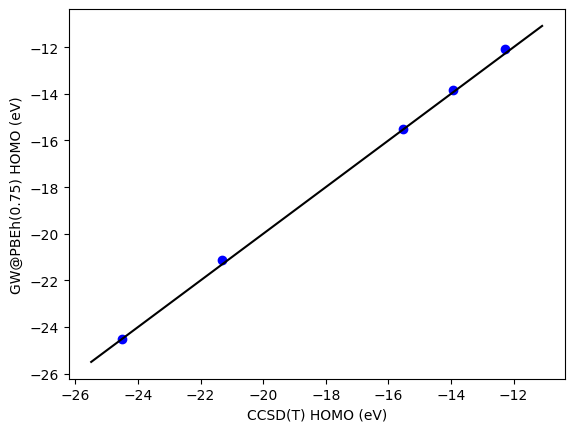

Mean Absolute Error:  0.112 (eV)
Mean Signed   Error:  0.112 (eV)
Maximum       Error:  0.212 (eV)


In [4]:
import matplotlib.pyplot as plt
from molgw.gw100 import ccsdt_homo

# Create a dictionary with the calculated GW HOMO energies
ehomo = {}
for cas, mlgo in mlgos.items():
    # homo_energy methods is handy
    ehomo[cas] = mlgo.homo_energy('gw')

for cas in ehomo.keys():
    plt.scatter(ccsdt_homo["data"][cas],ehomo[cas],color='blue')
plt.plot([min(ehomo.values())-1, max(ehomo.values())+1], [min(ehomo.values())-1, max(ehomo.values())+1],color='black')
plt.xlabel("CCSD(T) HOMO (eV)")
plt.ylabel("GW@PBEh(0.75) HOMO (eV)")
plt.show()
mae, mse, mxe = molgw.gw100.mae_mse_max(ccsdt_homo["data"],ehomo)
print(f"Mean Absolute Error: {mae: .3f} (eV)")
print(f"Mean Signed   Error: {mse: .3f} (eV)")
print(f"Maximum       Error: {mxe: .3f} (eV)")

As the calculations were too long, we had limited ourselves to a subset of the GW100 benchmark.
Below we use the values saved in molgw.gw100.g0w0_pbeh075_homo to plot the complete set.

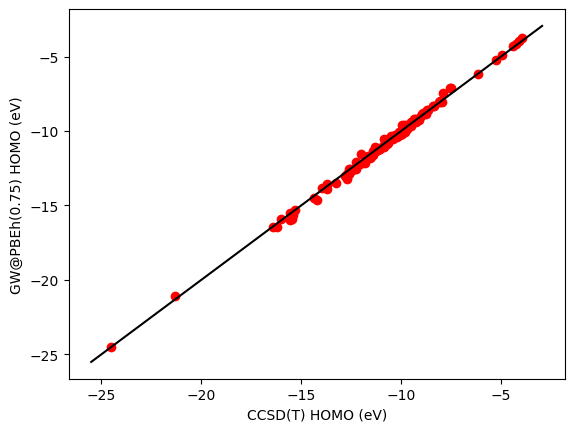

Mean Absolute Error:  0.149 (eV)
Mean Signed   Error: -0.027 (eV)
Maximum       Error:  0.495 (eV)


In [5]:
import matplotlib.pyplot as plt
from molgw.gw100 import g0w0_pbeh075_homo, ccsdt_homo

for cas in molgw.gw100.chemical_formulas.keys():
    plt.scatter(ccsdt_homo["data"][cas],g0w0_pbeh075_homo["data"][cas],color='red')
plt.plot([min(ccsdt_homo["data"].values())-1, max(ccsdt_homo["data"].values())+1], [min(ccsdt_homo["data"].values())-1, max(ccsdt_homo["data"].values())+1],color='black')
plt.xlabel("CCSD(T) HOMO (eV)")
plt.ylabel("GW@PBEh(0.75) HOMO (eV)")
plt.show()
mae, mse, mxe = molgw.gw100.mae_mse_max(ccsdt_homo["data"],g0w0_pbeh075_homo["data"])
print(f"Mean Absolute Error: {mae: .3f} (eV)")
print(f"Mean Signed   Error: {mse: .3f} (eV)")
print(f"Maximum       Error: {mxe: .3f} (eV)")